In [1]:
from tensorflow.keras.layers import Input
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from tensorflow.keras.applications.mobilenet import MobileNet
from nltk.tokenize import word_tokenize
import gensim
import pandas as pd
from nltk.corpus import stopwords
stop_english=set(stopwords.words('english'))
from gensim.models import FastText
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
#import cv2
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.compat.v1.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_metrics
from keras.preprocessing.image import load_img, img_to_array
%matplotlib inline

In [2]:
CATEGORIES = ['Electronics', 'Sports & Outdoors',
       'Cell Phones & Accessories', 'Automotive', 'Toys & Games',
       'Tools & Home Improvement', 'Health & Personal Care', 'Beauty',
       'Grocery & Gourmet Food', 'Office Products',
       'Arts, Crafts & Sewing', 'Pet Supplies', 'Patio, Lawn & Garden',
       'Clothing, Shoes & Jewelry', 'Baby',
       'Musical Instruments', 'Industrial & Scientific', 'Baby Products',
       'Appliances', 'All Beauty', 'All Electronics']

In [3]:
data = pd.read_csv("E:\ed\main project\data\Train.csv")
#pid = list(data['ImgId'])
#descriptions = list(data['description'])
data.head()

,ImgId,title,description,categories
0,B000HYL1V6,TUNGSTEN SOLDER PICK WITH HANDLE,Solder Pick for picking up molten solder when ...,"Arts, Crafts & Sewing"
1,B00006HXWY,Write Right 98167 Screen Protector for Sony T615C,We all screen. And we all need to protect thos...,Cell Phones & Accessories
2,B000GAWSBS,Casio Mens DBC310-1 Databank 300 Digital Watch...,"Bringing you precision at a glance, the Casio ...","Clothing, Shoes & Jewelry"
3,B000040JOL,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Tools & Home Improvement
4,B00006IB78,Energizer 2 in 1 Light,This twoway light features a bright flashlight...,Health & Personal Care


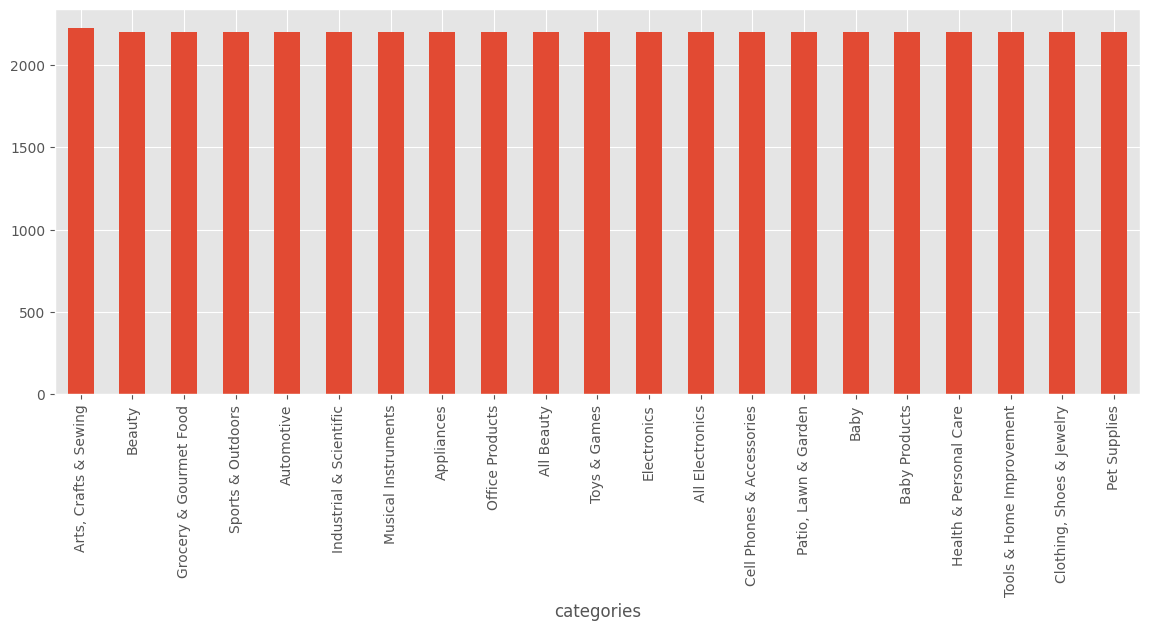

In [4]:
data['categories'].value_counts().plot(kind='bar', figsize=(14, 5));

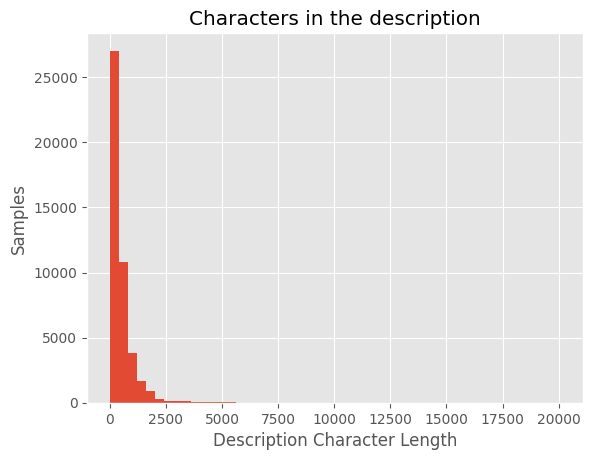

In [5]:
word_len=data['description'].str.len()
plt.hist(word_len, bins=50)
plt.ylabel('Samples')
plt.xlabel('Description Character Length')
plt.title('Characters in the description')
plt.show()

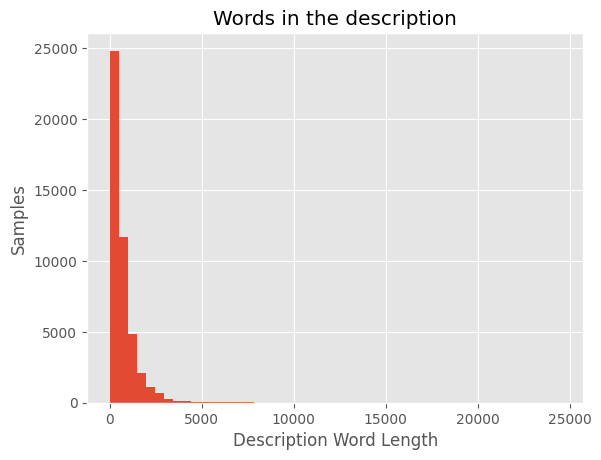

In [6]:
word_len=data['description'].str.split().map(lambda x: len(str(x)))
plt.hist(word_len, bins=50)
plt.ylabel('Samples')
plt.xlabel('Description Word Length');
plt.title('Words in the description')
plt.show()

In [7]:
train_images_path = "E:\ed\main project\data\\train\\train"
IMG_SIZE = (80,80)
INPUT_SHAPE = IMG_SIZE + (3,)
CALLBACK_PATIENCE = 10
BATCH_SIZE = 32
NUM_EPOCHS = 30
VALIDATION_SPLIT = .2
NUM_CLASSES = len(CATEGORIES)
L2_REGULARIZATION = 0.01

In [8]:
downloaded_files = []
for file in os.listdir(train_images_path):
    if file.endswith(".jpg"):
        downloaded_files.append(file.replace(".jpg", ""))
print(len(downloaded_files))

42000


In [9]:
def create_training_data(img):
    image = load_img(os.path.join(train_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

In [10]:
def get_token(description):
        # split the description into tokens (words)
        tokens = set(gensim.utils.tokenize(description))
        # Avoid words does not have atleast 2 character 
        tokens = [i for i in tokens if(len(i) > 2)]
        # Remove stop words
        tokens = [s for s in tokens if s not in stop_english]
        return tokens

In [11]:
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    x = x - 0.5
    x = x * 2.0
    return x

In [12]:
corpus = []
images = []
labels = []
files = os.listdir(train_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_training_data(img)
    if img_array is not None:
        try:
            index = data[data['ImgId']==img_id].index.values[0]
            row = data.iloc[index , :]
            family = row[3]
            if family in CATEGORIES:
                description = row[2]
                title = row[1]
                images.append(img_array.astype('float32'))
                token_list = get_token(str(title) + ' ' + str(description))
                corpus.append(token_list)
                class_num = CATEGORIES.index(family)
                labels.append(class_num)
        except IndexError as error:
            print(error)

images = np.asarray(images)
labels = pd.get_dummies(labels).values
images = preprocess_input(images)

C:\Users\Siva\AppData\Local\Temp\ipykernel_21376\3802926654.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  family = row[3]
C:\Users\Siva\AppData\Local\Temp\ipykernel_21376\3802926654.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  description = row[2]
C:\Users\Siva\AppData\Local\Temp\ipykernel_21376\3802926654.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  title = row[1]


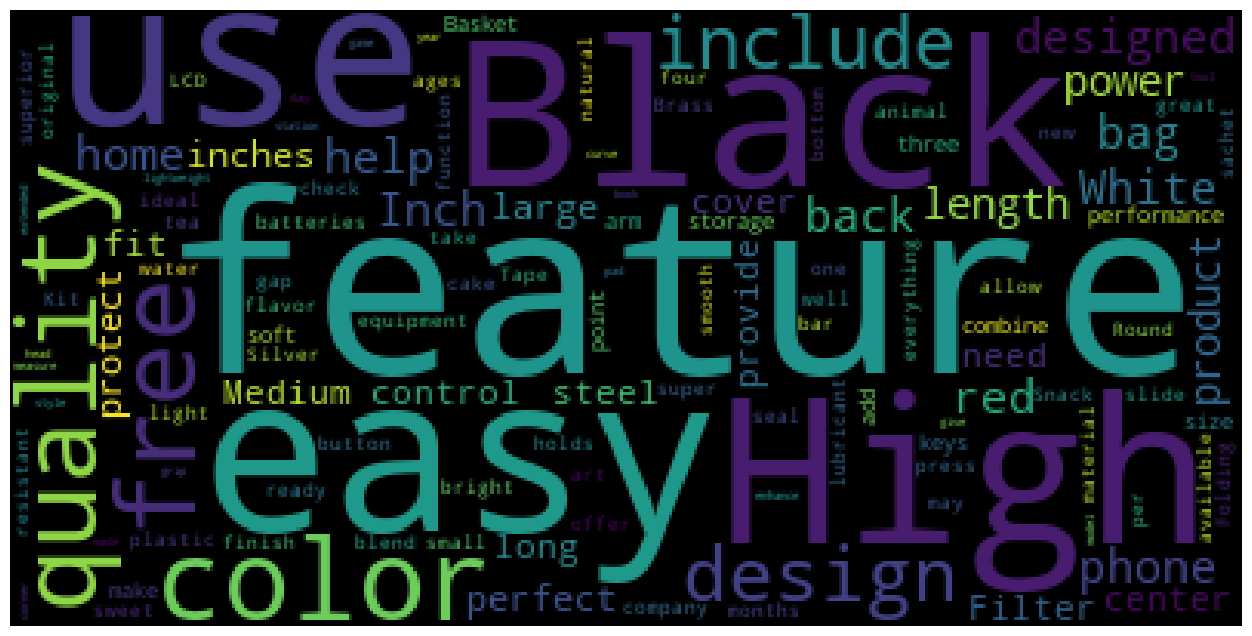

In [13]:
from wordcloud import WordCloud
plt.figure(figsize=(16,8))
text = [(" ").join(s) for s in corpus]
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(text[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [14]:
MAX_LEN=40
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

word_index=tokenizer_obj.word_index

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,300))

In [15]:
import gensim.downloader as api
model_fasttext = api.load("fasttext-wiki-news-subwords-300")
known_words = []
unknown_words = []
for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    if word in model_fasttext:
        known_words.append(word)
        embedding_matrix[i] = model_fasttext[word]
    else:
        unknown_words.append(word)

100%|████████████████████████████████████████████████████████████████████████| 72350/72350 [00:00<00:00, 306514.46it/s]


In [16]:
print(len(unknown_words))
print(len(known_words))
del model_fasttext

31996
40354


In [17]:
input_tensor = Input(shape=INPUT_SHAPE)
model = MobileNet(input_tensor=input_tensor, alpha=1.0,
                    include_top=False, weights=None)
output = tf.keras.layers.Reshape((4096,))(model.output)
output = tf.keras.layers.Dense(200, activation='relu')(output)
model.summary()



Model: "mobilenet_1.00_None"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 40, 40, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 40, 40, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 40, 40, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 40, 40, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 40, 40, 3

In [18]:
embedding_layer = tf.keras.layers.Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix),
                                            input_length=MAX_LEN,trainable=False)
dropout = tf.keras.layers.SpatialDropout1D(0.2)
#lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
#lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))
lstm = tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)
dense = tf.keras.layers.Dense(200, activation='relu')
embedding_model = tf.keras.Sequential([
    embedding_layer,
    dropout,
    lstm,
    dense 
])
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 300)           21705300  
                                                                 
 spatial_dropout1d (Spatial  (None, 40, 300)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense_1 (Dense)             (None, 200)               13000     
                                                                 
Total params: 21811740 (83.21 MB)
Trainable params: 106440 (415.78 KB)
Non-trainable params: 21705300 (82.80 MB)
_________________________________________________________________


In [19]:
merged = tf.keras.layers.Concatenate()([embedding_model.output, output])

normalize = tf.keras.layers.BatchNormalization()(merged)

final_dropout = tf.keras.layers.Dropout(0.2)(normalize)

dense_100 = tf.keras.layers.Dense(50, activation='relu')(final_dropout)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense_100)

final_model = tf.keras.Model(inputs=[model.input, embedding_model.input], outputs=output_layer)

In [20]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 40, 40, 32)           864       ['input_1[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 40, 40, 32)           128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 40, 40, 32)           0         ['conv1_bn[0][0]']        

In [21]:
p = int((len(images)*80)/100)
image_train = images[:p]
image_test = images[p:]
label_train = labels[:p]
label_test = labels[p:]
text_train = tweet_pad[:p]
text_test = tweet_pad[p:]

In [22]:
print('Shape of train',image_train.shape)
print("Shape of Validation ",image_test.shape)
print('Shape of train',label_train.shape)
print("Shape of Validation ",label_test.shape)
print("Shape of Text Train ",text_train.shape)

Shape of train (33600, 80, 80, 3)
Shape of Validation  (8400, 80, 80, 3)
Shape of train (33600, 21)
Shape of Validation  (8400, 21)
Shape of Text Train  (33600, 40)


In [23]:
from keras.preprocessing.image import ImageDataGenerator
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1, y, batch_size=BATCH_SIZE, shuffle=False)
    genX2 = gen.flow(X1, X2, batch_size=BATCH_SIZE, shuffle=False)
    i = 0
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]
            #yield X2i[1]

# Finally create generator
gen_flow = gen_flow_for_two_inputs(image_train, text_train, label_train)

In [24]:
import keras 
from keras import layers
from keras_metrics import precision, recall
regularization = tf.keras.regularizers.l2(L2_REGULARIZATION)
early_stop = EarlyStopping('val_loss', patience=CALLBACK_PATIENCE)
reduce_lr = ReduceLROnPlateau(
    'val_loss', factor=0.1, patience=int(CALLBACK_PATIENCE/4), verbose=1)
tensorboard = TensorBoard('./logs')
callbacks = [early_stop, reduce_lr, tensorboard]
#adam = tf.keras.optimizers.Adam(learning_rate=3e-4)
#optimizer = adam
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
tf.debugging.set_log_device_placement(True)
try:
  # Specify an invalid GPU device
  with tf.device('/GPU:0'):
    history = final_model.fit([image_train, text_train], label_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, verbose=1, callbacks=callbacks, steps_per_epoch=len(image_train) // BATCH_SIZE, validation_data=([image_test,text_test], label_test))
except RuntimeError as e:
  print(e)

E:\ed\Programs\Lib\site-packages\keras\src\initializers\__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops.Constant'>, which may lead to improper serialization.
  warnings.warn(


Epoch 1/30


1050/1050 [==============================] - 391s 362ms/step - loss: 2.1541 - accuracy: 0.3202 - val_loss: 1.6913 - val_accuracy: 0.4438 - lr: 0.0010
Epoch 2/30
1050/1050 [==============================] - 371s 353ms/step - loss: 1.6387 - accuracy: 0.4707 - val_loss: 1.3909 - val_accuracy: 0.5411 - lr: 0.0010
Epoch 3/30
1050/1050 [==============================] - 375s 357ms/step - loss: 1.4775 - accuracy: 0.5233 - val_loss: 1.3305 - val_accuracy: 0.5668 - lr: 0.0010
Epoch 4/30
1050/1050 [==============================] - 367s 350ms/step - loss: 1.3912 - accuracy: 0.5529 - val_loss: 1.2988 - val_accuracy: 0.5779 - lr: 0.0010
Epoch 5/30
1050/1050 [==============================] - 364s 346ms/step - loss: 1.3047 - accuracy: 0.5812 - val_loss: 1.1719 - val_accuracy: 0.6204 - lr: 0.0010
Epoch 6/30
1050/1050 [==============================] - 363s 346ms/step - loss: 1.2412 - accuracy: 0.6012 - val_loss: 1.2469 - val_accuracy: 0.6114 - lr: 0.0010
Epoch 7/30
1050/1050 [==========

In [26]:
#final_model.save_weights("saved_model/weights.h5")
#final_model.load_weights("static/weights.h5")

In [27]:
predictions = final_model.predict([image_test,text_test],batch_size=1,verbose = 2)
classes = np.argmax(predictions, axis = 1)
y_test = np.argmax(label_test, axis = 1)

8400/8400 - 189s - 189s/epoch - 22ms/step


In [28]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,classes)

Text(0.5, 135.7222222222222, 'Predicted label')

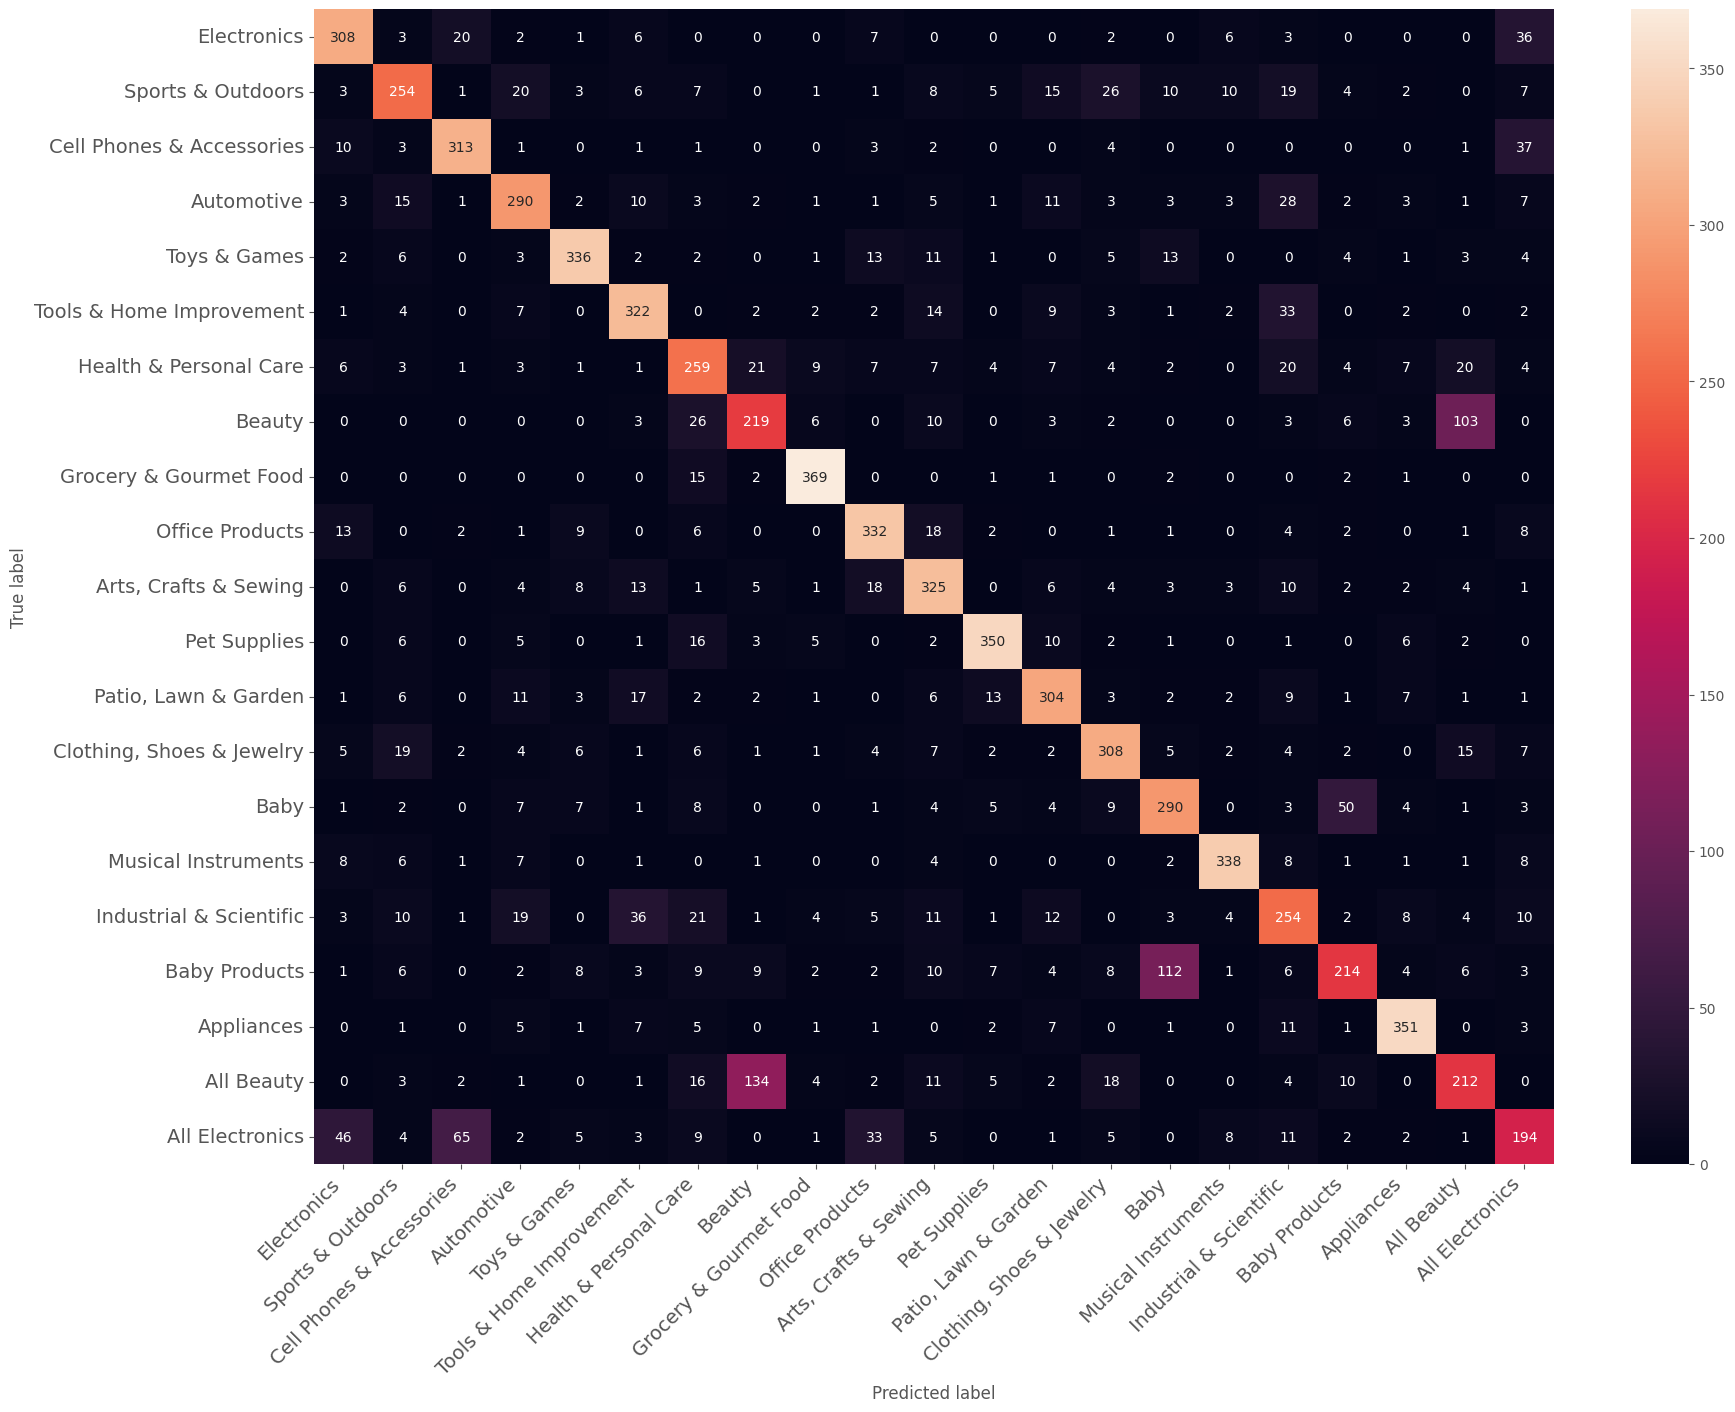

In [29]:
import seaborn as sns
df_cm = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

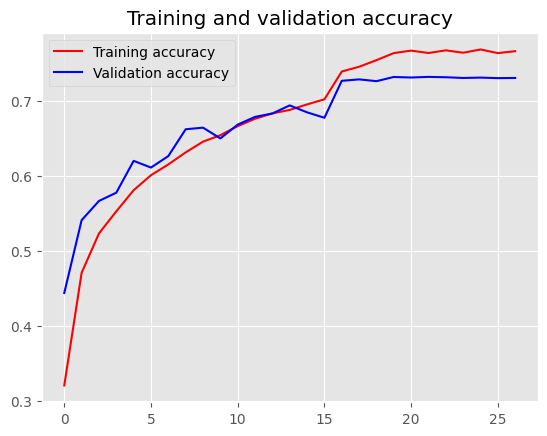

<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

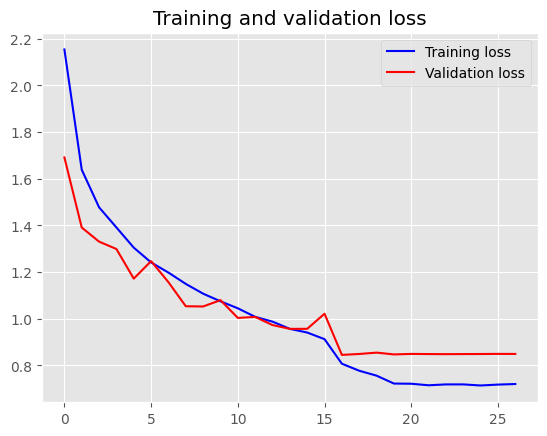

In [31]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [32]:
intermediate_layer_model = tf.keras.Model(inputs=final_model.input,
                                       outputs=final_model.layers[-1].output)
intermediate_output = intermediate_layer_model([image_train[:10000], text_train[:10000]])

y_train = np.argmax(label_train, axis = 1)
tsne_label = []
for i in range(10000):
    tsne_label.append(str(CATEGORIES[y_train[i]]))

In [33]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.manifold import TSNE
X = preprocessing.normalize(intermediate_output)
y = tsne_label
le = LabelEncoder()
y = le.fit_transform(y)

C:\Users\Siva\AppData\Local\Temp\ipykernel_21376\1927282817.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=np.random.rand(3,), label=label)


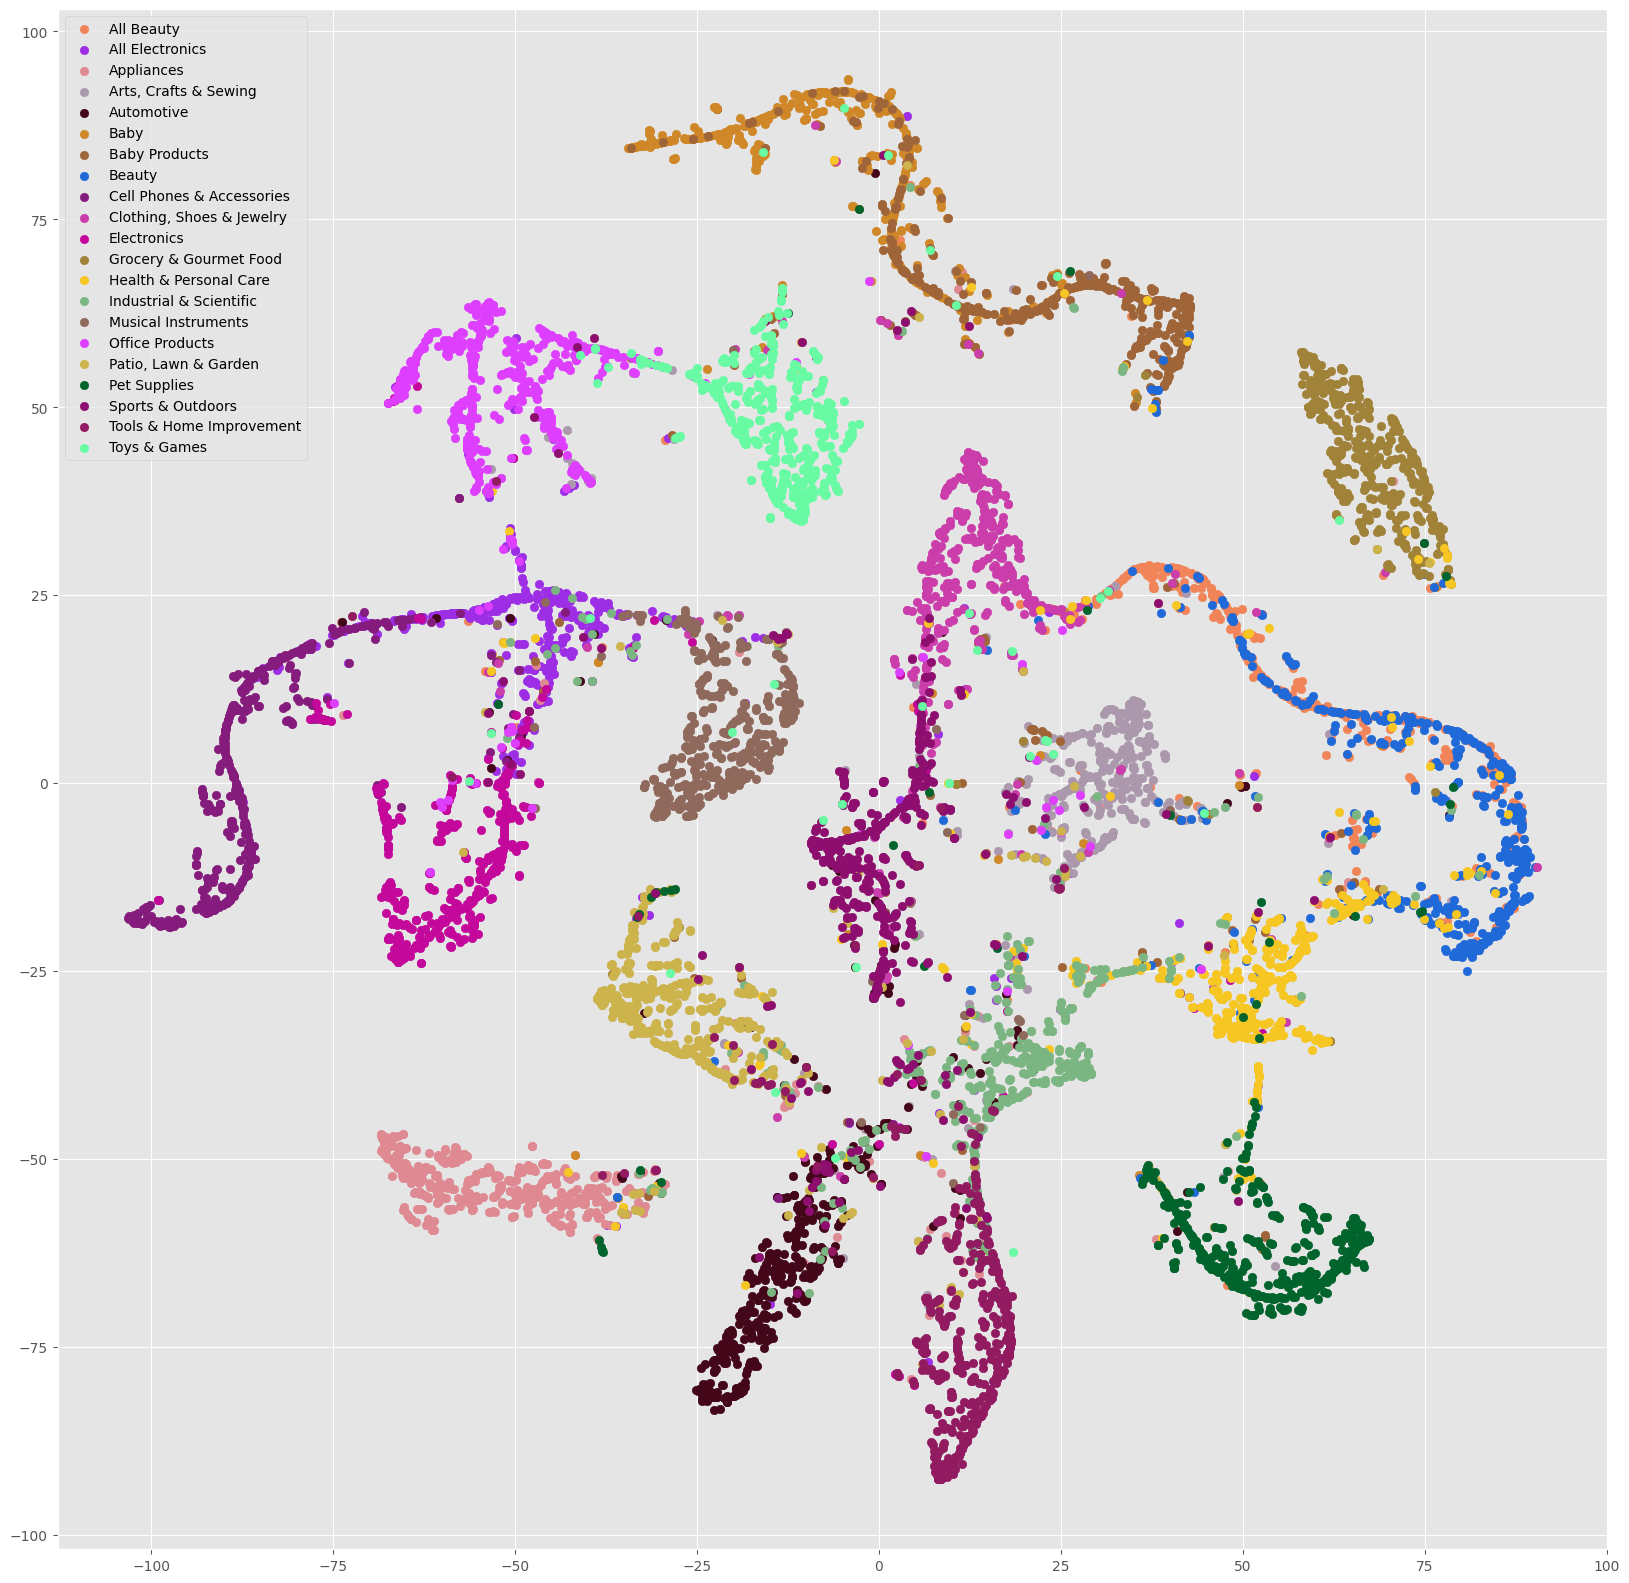

In [34]:
tsne = TSNE(n_components=2, random_state=0)
target_ids = range(len(le.classes_))

X_2d = tsne.fit_transform(X)

plt.figure(figsize=(20, 20))
for i, label in zip(target_ids, le.classes_):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=np.random.rand(3,), label=label)
plt.legend()
plt.show()

In [35]:
data_test = pd.read_csv(r"E:\ed\main project\data\\test.csv")
data_test.head(10)

,ImgId,title,description
0,B0006IK25E,Jacquard Textile Paint 2.25 Oz Pink,Jacquard Textile Pink Color in 2.25 ounces can...
1,B000GBRO16,Fimo Soft Polymer Clay 2 Ounces-8020-33 Brilli...,Fimo Soft Polymer Clay is easier to use than b...
2,B000H6OZGW,Sculpey III 2 Oz. Polymer Clay: Pale Pistachio,Sculpey 3 Polymer Clay is America's original o...
3,B000BR28KC,Sennelier Soft Pastel Turquoise Green 724,Handmade since 1900 Sennelier extra-fine soft ...
4,B0006IK27M,Jacquard Textile Colors sapphire blue,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
5,B0000AZ6NS,"Sudbury Heavy Duty ELASTO Sealant, White, CART...","Elastomeric marine sealant. One part, fast ski..."
6,B0006IK268,Jacquard Textile Colors ruby red,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
7,B000FNDZN6,Dylon Permanent Fabric Dye -Olive,Permanent Fabric Dye will not fade or wash awa...
8,B000GBO8UG,Fimo Soft Polymer Clay 2 Ounces-8020-70 Sahara,Fimo Soft Polymer Clay is easier to use than b...
9,B0006IK2FE,Jacquard Textile Colors yellow ochre,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...


In [36]:
del image_train
del image_test
del label_train
del label_test
del text_train
del text_test
del images
del data

In [37]:
def get_token(description):
    token = list(gensim.utils.tokenize(description))
    token = [i for i in token if(len(i) > 2)]
    token = [s for s in token if s not in stop_english]
    return token

In [38]:
test_images_path = 'E:\ed\main project\data\\test'
def create_test_data(img):
    image = load_img(os.path.join(test_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

In [41]:
test_image_ids = []
test_corpus = []
test_images = []
files = os.listdir(test_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_test_data(img)
    if img_array is not None:
        try:
            index = data_test[data_test['ImgId']==img_id].index.values[0]
            row = data_test.iloc[index , :]
            description = row[2]
            title = row[1]
            test_images.append(img_array.astype('float32'))
            test_corpus.append(get_token(str(title) + ' ' + str(description)))
            test_image_ids.append(img_id)
        except IndexError as error:
            print(error)

#tokenizer_obj=Tokenizer()
#tokenizer_obj.fit_on_texts(corpus)
#sequences=tokenizer_obj.texts_to_sequences(corpus)
#tokenizer_obj=Tokenizer()
sequences=tokenizer_obj.texts_to_sequences(test_corpus)
test_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')
test_images = np.asarray(test_images)
test_images = preprocess_input(test_images)

C:\Users\Siva\AppData\Local\Temp\ipykernel_21376\3684740095.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  description = row[2]
C:\Users\Siva\AppData\Local\Temp\ipykernel_21376\3684740095.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  title = row[1]


In [42]:
pred = final_model.predict([test_images, test_pad],batch_size=1,verbose = 2)
test_classes = np.argmax(pred, axis = 1)

6367/6367 - 493s - 493s/epoch - 77ms/step


In [45]:
from sklearn.metrics.pairwise import cosine_similarity
cosSimilarities = cosine_similarity(pred)

In [46]:
import csv
with open('submission.csv', mode='w') as metadata_file:
    metadata_writer = csv.writer(metadata_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    metadata_writer.writerow(['ImgId', 'category'])
    for i, val in enumerate(test_classes):
        metadata_writer.writerow([test_image_ids[i], test_classes[i]])

In [65]:
test_images_path = 'E:\ed\main project\data\\test\\'
tfiles = [test_images_path + x for x in os.listdir(test_images_path) if "jpg" in x]
print(len(tfiles))

6367


In [96]:
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=tfiles, index=tfiles)
cos_similarities_df.head()

,E:\ed\main project\data\test\098415096X.jpg,E:\ed\main project\data\test\1134872615.jpg,E:\ed\main project\data\test\1403710066.jpg,E:\ed\main project\data\test\1403737010.jpg,E:\ed\main project\data\test\1403742618.jpg,E:\ed\main project\data\test\1403765049.jpg,E:\ed\main project\data\test\1403766355.jpg,E:\ed\main project\data\test\1403778809.jpg,E:\ed\main project\data\test\1403794677.jpg,E:\ed\main project\data\test\1427616566.jpg,...,E:\ed\main project\data\test\B00C2QSVIS.jpg,E:\ed\main project\data\test\B00C3FRLVG.jpg,E:\ed\main project\data\test\B00C7MGZGW.jpg,E:\ed\main project\data\test\B00C7OK5FM.jpg,E:\ed\main project\data\test\B00CBYE0E0.jpg,E:\ed\main project\data\test\B00CC5SIY6.jpg,E:\ed\main project\data\test\B00CCNTP7W.jpg,E:\ed\main project\data\test\B00CCNZEMM.jpg,E:\ed\main project\data\test\B00CF38SAO.jpg,E:\ed\main project\data\test\B00CFCLAVE.jpg
E:\ed\main project\data\test\098415096X.jpg,1.000000,0.053880,0.011833,0.001865,0.160074,0.033963,0.002928,0.000829,0.005304,0.006321,...,0.035916,0.004963,0.968556,0.008817,0.022721,0.014938,0.135343,0.005653,0.033606,0.031023
E:\ed\main project\data\test\1134872615.jpg,0.053880,1.000000,0.008290,0.006648,0.482968,0.003880,0.026869,0.000295,0.012570,0.032742,...,0.021614,0.000427,0.000450,0.176560,0.721685,0.271424,0.057433,0.006219,0.274658,0.001008
E:\ed\main project\data\test\1403710066.jpg,0.011833,0.008290,1.000000,0.000027,0.246872,0.076424,0.007333,0.000227,0.767098,0.005333,...,0.001273,0.000087,0.005116,0.008207,0.043642,0.001456,0.037394,0.640087,0.072734,0.034267
E:\ed\main project\data\test\1403737010.jpg,0.001865,0.006648,0.000027,1.000000,0.001400,0.000197,0.982324,0.000007,0.001558,0.000571,...,0.000002,0.000001,0.000004,0.018855,0.010679,0.000118,0.005097,0.000044,0.012742,0.000002
E:\ed\main project\data\test\1403742618.jpg,0.160074,0.482968,0.246872,0.001400,1.000000,0.112944,0.015761,0.000529,0.144838,0.003988,...,0.021167,0.000561,0.010963,0.071838,0.098895,0.094323,0.153389,0.213419,0.150010,0.101972


In [105]:
cos_similarities_df.to_csv('cos_similarities.csv', index=True, header=True)


In [106]:
nb_closest_images = 5
# function to retrieve the most similar products for a given one

def retrieve_most_similar_products(products):

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(products, target_size=(400,400))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_prods = cos_similarities_df[products].sort_values(ascending=False)[1:nb_closest_images].index
    closest_prods_scores = cos_similarities_df[products].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_prods)):
        original = load_img(closest_prods[i], target_size=(400, 400))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_prods_scores[i])

-----------------------------------------------------------------------
original product:


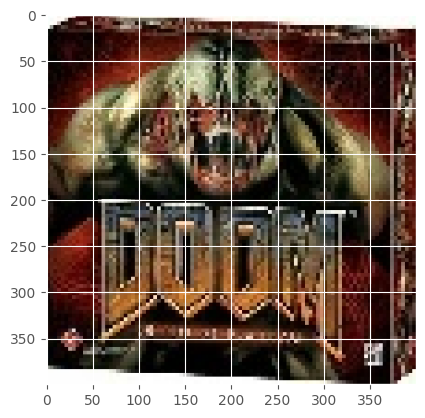

-----------------------------------------------------------------------
most similar products:


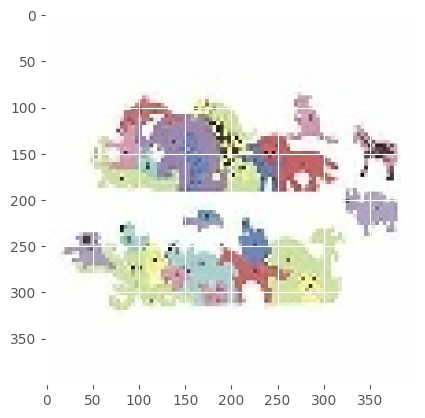

C:\Users\Siva\AppData\Local\Temp\ipykernel_21376\1668743369.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("similarity score : ",closest_prods_scores[i])


similarity score :  0.9996754


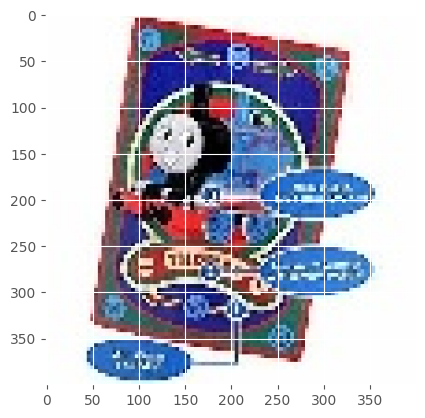

similarity score :  0.996067


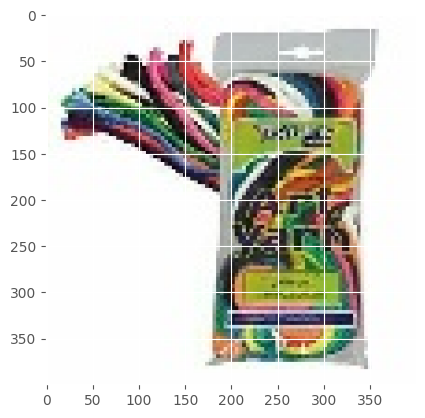

similarity score :  0.9938763


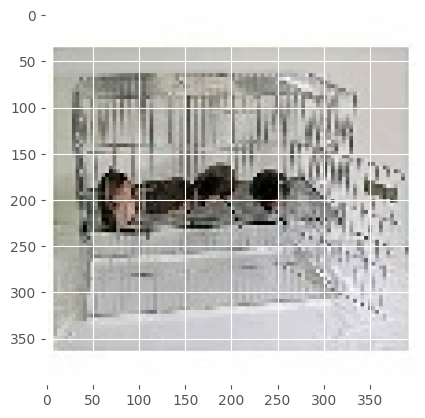

similarity score :  0.9935601


In [107]:
retrieve_most_similar_products(tfiles[38])